# Quantium Experimentation and Uplift Testing

#### Ben Crabtree

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import xlrd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('data.csv')

### Performance Metrics

We would like to determine the effectiveness of new trial layouts in trial stores 77, 86 and 88 for the trial period of February 2019 to April 2019. We would like to measure the performance of these stores on three metrics:

- Total sales revenue
- Total number of customers
- Average number of transactions per customer

We will calculate these by month over the period of interest.

Firstly, we order the rows in terms of date, making sure the date column is in datetime format. Then, we create a year-month column of the form YYYY-MM. This will allow us to define a function to calculate a given metric month by month for a certain store, returning these monthly calculations as a vector. These vectors will be of the same length for each store (the number of months in the period of interest), allowing us to compare different stores on a given metric using the Pearson correlation coefficient.  We can define such a function for each of the metrics above.

#### Order By Date

In [5]:
data = data.sort_values(by=['DATE'])

#### Convert Date Column To Datetime Type

In [6]:
data['DATE'] = pd.to_datetime(data['DATE']) 

#### Create Year-Month Column

In [7]:
data['YEAR_MONTH'] = pd.to_datetime(data['DATE']).dt.to_period('M')
data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER,BRAND,PACK_SIZE,YEAR_MONTH
22186,2018-07-01,207,207118,205283,39,Smiths Crinkle Cut Tomato Salsa 150g,2,5.2,MIDAGE SINGLES/COUPLES,Premium,Smiths,150,2018-07
23251,2018-07-01,251,251207,253270,63,Kettle 135g Swt Pot Sea Salt,2,8.4,MIDAGE SINGLES/COUPLES,Premium,Kettle,135,2018-07
133354,2018-07-01,75,75163,74054,20,Doritos Cheese Supreme 330g,2,11.4,RETIREES,Budget,Doritos,330,2018-07
23305,2018-07-01,255,255451,255072,114,Kettle Sensations Siracha Lime 150g,1,4.6,MIDAGE SINGLES/COUPLES,Premium,Kettle,150,2018-07
217278,2018-07-01,24,24151,21152,62,Pringles Mystery Flavour 134g,2,7.4,YOUNG SINGLES/COUPLES,Budget,Pringles,134,2018-07


#### Define Functions to Calculate Monthly Metrics For a Given Store

In [8]:
def total_sales(store_data):
    '''
    Input: Takes a dataframe store_data which is filtered on a particular store number
    Returns: A vector containing the total sales by month for that store
    '''
    sales = [] 
    months = store_data.YEAR_MONTH.unique()
    for month in months:
        month_data = store_data[store_data.YEAR_MONTH == month]
        revenue = round(month_data.TOT_SALES.sum(), 2)
        sales.append(revenue)
    return pd.Series(sales)

def total_customers(store_data):
    '''
    Input: Takes a dataframe store_data which is filtered on a particular store number
    Returns: A vector containing the number of unique customers by month for that store
    '''
    customers = [] 
    months = store_data.YEAR_MONTH.unique()
    for month in months:
        month_data = store_data[store_data.YEAR_MONTH == month]
        num_cust = len(month_data.LYLTY_CARD_NBR.unique())
        customers.append(num_cust)
    return pd.Series(customers)

def avg_transactions(store_data):
    '''
    Input: Takes a dataframe store_data which is filtered on a particular store number
    Returns: A vector containing the average number of transactions per customer by month
             for that store calculated by (number of transactions / number of unique customers)
    '''
    transactions = [] 
    months = store_data.YEAR_MONTH.unique()
    for month in months:
        month_data = store_data[store_data.YEAR_MONTH == month]
        avg_trans = len(month_data) / len(month_data.LYLTY_CARD_NBR.unique())
        transactions.append(round(avg_trans, 2))
    return pd.Series(transactions)

### Choosing Control Stores

In order to determine if the trial stores perform better on the metrics we have defined, we will assign a control store (in which there is no new layout) to each trial store to make the comparison.

When choosing a corresponding control store for each trial store we want to choose a control store that is similar to the trial store in terms of performance in the pre-trial period of July 2018 to January 2019. Then, we can compare if and how performance diverges during the trial period. Since our dataset is sampled from the period July 2018 to June 2019, this should not be a problem.

We split the data into the pre-trial period (July 2018 to January 2019) and trial period (February 2019 to April 2019). Then for each period we separate out the three trial stores from the potential controls.

In order to form optimal trial-control pairings for each trial store, we make pairwise comparisons between each trial store and each potential control store to determine similarity using the monthly metric functions defined above. Over the pre-trial period we will determine the correlation between pairs of stores on the metrics:

- Total sales revenue
- Total number of customers

We calculate both these metrics by month for each (potential control, trial) pair.

Then for each trial store, we will select the control store that has the highest correlation, averaged over the 2 correlation coefficients calculated, giving us 3 optimal trial-control pairs.

#### Set Date Column as Index

In [9]:
data = data.set_index(['DATE'])

#### Split Data Into Pre-Trial and Trial Periods

In [10]:
pre_trial = data.loc['2018-07-01' : '2019-01-31']
trial = data.loc['2019-02-01' : '2019-04-30']

#### Separate Control Candidates from Trial Stores 

In [11]:
pretrial_candidates = pre_trial.loc[(pre_trial['STORE_NBR'] != 77) & (pre_trial['STORE_NBR'] != 86) & (pre_trial['STORE_NBR'] != 88)]

pre_store_nums = np.sort(pretrial_candidates.STORE_NBR.unique())

pretrial_77 = pre_trial.loc[pre_trial['STORE_NBR'] == 77]
pretrial_86 = pre_trial.loc[pre_trial['STORE_NBR'] == 86]
pretrial_88 = pre_trial.loc[pre_trial['STORE_NBR'] == 88]

print(len(pretrial_77))
print(len(pretrial_86))
print(len(pretrial_88))

305
845
1028


In [12]:
trial_candidates = trial.loc[(trial['STORE_NBR'] != 77) & (trial['STORE_NBR'] != 86) & (trial['STORE_NBR'] != 88)]

trial_store_nums = np.sort(trial_candidates.STORE_NBR.unique())

trial_77 = trial.loc[trial['STORE_NBR'] == 77]
trial_86 = trial.loc[trial['STORE_NBR'] == 86]
trial_88 = trial.loc[trial['STORE_NBR'] == 88]

print(len(trial_77))
print(len(trial_86))
print(len(trial_88))

142
387
470


We check to make sure that we have the same set of stores in the pretrial and trial periods and find that in the pretrial period stores 11, 31, 76 and 85 appear but in the trial period they don't. We can filter these out as candidates as we need stores for which we have data across both periods.

In [13]:
set(pre_store_nums) - set(trial_store_nums)

{11, 31, 76, 85}

In [14]:
pretrial_candidates = pretrial_candidates.loc[(pretrial_candidates['STORE_NBR'] != 11) & (pretrial_candidates['STORE_NBR'] != 31) & (pretrial_candidates['STORE_NBR'] != 76) & (pretrial_candidates['STORE_NBR'] != 85)]
pre_store_nums = np.sort(pretrial_candidates.STORE_NBR.unique())
#print(pre_store_nums)

#### Make Pairwise Comparisons Between Control Candidates and Trial Stores

In [71]:
def max_correlation(trial_data, store_nums):
    
    '''
    Input: A dataframe trial_data which contains rows filtered on a particular trial store.
           A list of store numbers store_nums for comparison with the trial store
    
    Output: A tuple of the form:
            
            (store number, sales correlation, customer correlateion, avg correlation)
            
            The tuple returned has the largest average correlation (last element)
            out of all the pairwise comparisons made.
            
            The average correlation is taken over the 2 correlation coefficients calculated,
            one for total sales and the other for total customers.

    '''
    
    avg_corrs = []
    
    trial_sales = total_sales(trial_data)
    trial_customers = total_customers(trial_data)
    
    for num in store_nums:
        candidate_data = data.loc[data['STORE_NBR'] == num]
        
        candidate_sales = total_sales(candidate_data)
        candidate_customers = total_customers(candidate_data)
        
        sales_corr = round(trial_sales.corr(candidate_sales), 2)
        customers_corr = round(trial_customers.corr(candidate_customers), 2)
        
        avg_corrs.append( (num, sales_corr, customers_corr, round((sales_corr + customers_corr)/2, 2)) )
        
    return max(avg_corrs,key=lambda item:item[3])

#### Find the Optimal Control Store for Each Trial Store

Using the max correlation function, we see that the highest average correlations across the total sales and total customer metrics are:
- Store 77 with Store 233
- Store 86 with Store 114
- Store 88 with store 14

So these are the trial store, control store pairings we will examine using data from the trial period.

In [72]:
max_correlation(pretrial_77, pre_store_nums)

(233, 0.98, 0.96, 0.97)

In [73]:
max_correlation(pretrial_86, pre_store_nums)

(114, 0.8, 0.88, 0.84)

In [74]:
max_correlation(pretrial_88, pre_store_nums)

(14, 0.6, 0.98, 0.79)

#### Line Plots Verifying Correlation

We can verify the correlations on each metric between the trial-control store pairs visually by making line plots over the pre-trial period. The lines with o's represent the trial store and the lines with x's represent the control stores. We see that for most trial-control pairs the correlations are quite close. But there appears to be quite a large gap in the metrics for trial store 88 and control store 14 even though they are a highly correlated pair across the total sales and total customers metrics.

In [19]:
pretrial_233 = pre_trial.loc[pre_trial['STORE_NBR'] == 233]

pretrial77_sales = total_sales(pretrial_77)
pretrial233_sales = total_sales(pretrial_233)

pretrial77_customers = total_customers(pretrial_77)
pretrial233_customers = total_customers(pretrial_233)

Text(0.5,1,'Total Sales in Pretrial Period')

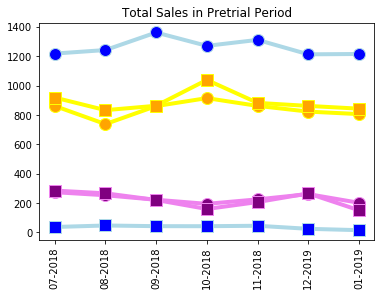

In [93]:
#  Trial Stores (o) and Control Stores (x)
months = ['07-2018', '08-2018', '09-2018', '10-2018', '11-2018', '12-2019', '01-2019']
plt.plot(months, pretrial77_sales, marker='o', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, pretrial233_sales, marker='s', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, pretrial86_sales, marker='o', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, pretrial114_sales, marker='s', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, pretrial88_sales, marker='o', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.plot(months, pretrial14_sales, marker='s', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.xticks(rotation=90)
plt.title('Total Sales in Pretrial Period')

Text(0.5,1,'Total Customers in Pretrial Period')

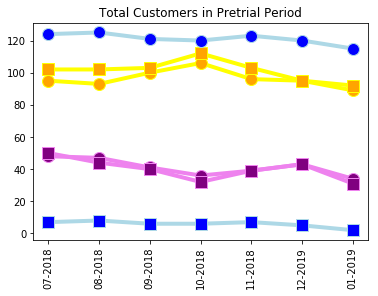

In [92]:
months = ['07-2018', '08-2018', '09-2018', '10-2018', '11-2018', '12-2019', '01-2019']
plt.plot(months, pretrial77_customers, marker='o', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, pretrial233_customers, marker='s', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, pretrial86_customers, marker='o', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, pretrial114_customers, marker='s', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, pretrial88_customers, marker='o', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.plot(months, pretrial14_customers, marker='s', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.xticks(rotation=90)
plt.title('Total Customers in Pretrial Period')

### Uplift Analysis

We wish to compare the performances of the trial stores to the performances of the control stores to determine if the performance of the trial stores improves significantly during the trial period relative to the control stores. If the metrics we have defined are improving in our trial stores during the trial period but not in the corresponding control stores this suggests that the new trial layouts are having a positive effect.

In order to make this comparison, we can calculate a total sales vector, total customers vector and average transactions per customer vector for each trial store and its control during the pretrial period and the trial period. For each store and each metric we subtract the mean of the pretrial period vector from the mean of the trial period vector. If the difference in means is positive, there was an increase in that metric for that store during the trial period. We can do this for each trial store and put the differences in a vector, and for each control store and put the differences in a vector. We can then perform one-sided independent two sample t-tests to compare the vector of trial store differences and the vector of control store differences for each metric.

In [28]:
trial_233 = trial.loc[trial['STORE_NBR'] == 233]

trial77_sales = total_sales(trial_77)
trial233_sales = total_sales(trial_233)

trial77_customers = total_customers(trial_77)
trial233_customers = total_customers(trial_233)

trial77_transactions = avg_transactions(trial_77)
trial233_transactions = avg_transactions(trial_233)

trial_114 = trial.loc[trial['STORE_NBR'] == 114]

trial86_sales = total_sales(trial_86)
trial114_sales = total_sales(trial_114)

trial86_customers = total_customers(trial_86)
trial114_customers = total_customers(trial_114)

trial86_transactions = avg_transactions(trial_86)
trial114_transactions = avg_transactions(trial_114)

trial_14 = trial.loc[trial['STORE_NBR'] == 14]

trial88_sales = total_sales(trial_88)
trial14_sales = total_sales(trial_14)

trial88_customers = total_customers(trial_88)
trial14_customers = total_customers(trial_14)

trial88_transactions = avg_transactions(trial_88)
trial14_transactions = avg_transactions(trial_14)

pretrial77_transactions = avg_transactions(pretrial_77)
pretrial86_transactions = avg_transactions(pretrial_86)
pretrial88_transactions = avg_transactions(pretrial_88)

pretrial233_transactions = avg_transactions(pretrial_233)
pretrial114_transactions = avg_transactions(pretrial_114)
pretrial14_transactions = avg_transactions(pretrial_14)

In [62]:
diff_sales_77 = trial77_sales.mean() - pretrial77_sales.mean()
diff_sales_86 = trial86_sales.mean() - pretrial86_sales.mean()
diff_sales_88 = trial88_sales.mean() - pretrial88_sales.mean()

diff_sales_233 = trial233_sales.mean() - pretrial233_sales.mean()
diff_sales_114 = trial114_sales.mean() - pretrial114_sales.mean()
diff_sales_14 = trial14_sales.mean() - pretrial14_sales.mean()

diff_customers_77 = trial77_customers.mean() - pretrial77_customers.mean()
diff_customers_86 = trial86_customers.mean() - pretrial86_customers.mean()
diff_customers_88 = trial88_customers.mean() - pretrial88_customers.mean()

diff_customers_233 = trial233_customers.mean() - pretrial233_customers.mean()
diff_customers_114 = trial114_customers.mean() - pretrial114_customers.mean()
diff_customers_14 = trial14_customers.mean() - pretrial14_customers.mean()

diff_transactions_77 = trial77_transactions.mean() - pretrial77_transactions.mean()
diff_transactions_86 = trial86_transactions.mean() - pretrial86_transactions.mean()
diff_transactions_88 = trial88_transactions.mean() - pretrial88_transactions.mean()

diff_transactions_233 = trial233_transactions.mean() - pretrial233_transactions.mean()
diff_transactions_114 = trial114_transactions.mean() - pretrial114_transactions.mean()
diff_transactions_14 = trial14_transactions.mean() - pretrial14_transactions.mean()


diff_sales_trial = [diff_sales_77, diff_sales_86, diff_sales_88]
diff_sales_control = [diff_sales_233, diff_sales_114, diff_sales_14]
diff_customers_trial = [diff_customers_77, diff_customers_86, diff_customers_88]
diff_customers_control = [diff_customers_233, diff_customers_114, diff_customers_14]
diff_transactions_trial = [diff_transactions_77, diff_transactions_86, diff_transactions_88]
diff_transactions_control = [diff_transactions_233, diff_transactions_114, diff_transactions_14]

#### Line Plots Demonstrating Divergence over Trial Period

Text(0.5,1,'Total Sales in Trial Period')

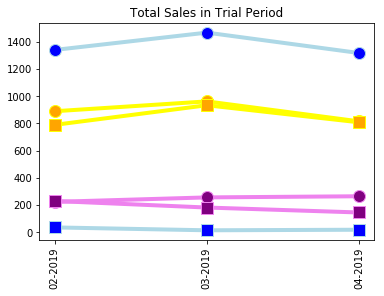

In [95]:
months = ['02-2019', '03-2019', '04-2019']
plt.plot(months, trial77_sales, marker='o', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, trial233_sales, marker='s', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, trial86_sales, marker='o', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, trial114_sales, marker='s', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, trial88_sales, marker='o', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.plot(months, trial14_sales, marker='s', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.xticks(rotation=90)
plt.title('Total Sales in Trial Period')

Text(0.5,1,'Total Customers in Trial Period')

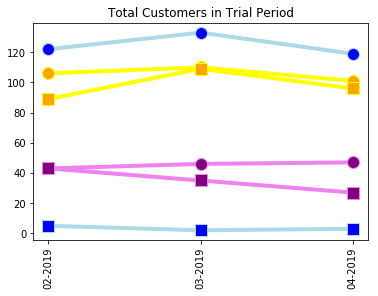

In [96]:
months = ['02-2019', '03-2019', '04-2019']
plt.plot(months, trial77_customers, marker='o', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, trial233_customers, marker='s', markerfacecolor='purple', markersize=12, color='violet', linewidth=4)
plt.plot(months, trial86_customers, marker='o', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, trial114_customers, marker='s', markerfacecolor='orange', markersize=12, color='yellow', linewidth=4)
plt.plot(months, trial88_customers, marker='o', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.plot(months, trial14_customers, marker='s', markerfacecolor='blue', markersize=12, color='lightblue', linewidth=4)
plt.xticks(rotation=90)
plt.title('Total Customers in Trial Period')

#### One-Tailed Independent Two Sample t-tests

We perform t-tests by metric to determine if there is a significant improvement in the performance of the trial stores over the control stores for a given metric during the trial period.

For each test we have two independent samples with 3 observations (one for each store in the sample). Each of these observations is the difference in the mean of a given metric over the trial period from the mean of the metric during the pre-trial period. If the difference is positive, this indicates that store performed better on  that metric over that trial period.

In each t-test, one sample contains differences for the trial stores and the other sample contains differences for the control stores. We wish to determine if the differences for the trial stores are significantly greater than those for the control stores for each metric, so we will perform a one-tailed independent two sampled t-test for each metric.

For each metric, we will be testing the hypotheses:

- H0: trial store differences mean <= control store differences mean

- H1: trial store differences mean > control store differences mean

We will test these at the 5% significance level.

In each case, we divide the p-value by 2 because the t-test in the python stats module is two-tailed and we are interested in testing a one-tailed hypothesis. When taken in combination with the observed test statistic, we can adapt this to a one-tailed test. If the p-value < 0.05 and the test statistic is positive there is evidence to reject the null hypothesis.

We find that for the total sales metric, the observed test statistic of 3.03 is positive and gives a low p-value of 0.036 < 0.05, suggesting that there is evidence that we should reject the null hypothesis that the mean of the trial store differences is less than or equal to the mean of the control store differences.

For the total customers metric, the observed test statistic of 4.68 is also positive and gives an even lower p-value of 0.013 < 0.05, again suggesting that there is evidence that we should reject the null hypothesis.

For the average transactions per customer metric, the observed test statistic -0.40 is negative, indicating that the mean for the trial stores is less than the mean for the control stores. The p-value is higher at 0.361 > 0.05. So we can not reject the null hypothesis that there is no difference in results between trial and control stores on this metric. These results aren't surprising since we did not select control stores based on correlation on this metric. 

Thus we conclude that there is evidence to suggest that the trial stores performed better on total sales and total customers during the trial period relative to the control stores, but not in average transactions per customer.

In [63]:
sales_t = stats.ttest_ind(diff_sales_trial, diff_sales_control, equal_var=False)
customers_t = stats.ttest_ind(diff_customers_trial, diff_customers_control, equal_var=False)
transactions_t = stats.ttest_ind(diff_transactions_trial, diff_transactions_control, equal_var=False)

print('Total Sales Metric p-value: ', round(sales_t.pvalue/2, 3))
print('Total Sales Metric observed test statistic: ',  round(sales_t.statistic, 3))
print()
print('Total Customers Metric p-value: ', round(customers_t.pvalue/2, 3))
print('Total Customers Metric observed test statistic: ', round(customers_t.statistic, 3))
print()
print('Average Transactions Per Customer Metric p-value: ', round(transactions_t.pvalue/2, 3))
print('Average Transactions Per Customer Metric observed test statistic: ', round(transactions_t.statistic, 3))

Total Sales Metric p-value:  0.036
Total Sales Metric observed test statistic:  3.031

Total Customers Metric p-value:  0.013
Total Customers Metric observed test statistic:  4.686

Average Transactions Per Customer Metric p-value:  0.361
Average Transactions Per Customer Metric observed test statistic:  -0.405


#### Plotting Distribution of Differences in Metrics over Trial and Control Stores

From the first pair of box plots we see that total sales went up during the trial period for all the trial stores and went down for all the control stores.

From the second pair of box plots we see a similar result with the total number of customers going up for all 3 trial stores over the trial period and going down for the 3 control stores.

In the last pair of box plots we see that the trial stores had a greater range of differences in average transactions per customer between the pretrial and trial periods, with some stores seeing this average go down in the trial period. In contrast the control stores all saw this average go up over the trial period.

So these plots also support the inference that the trial layouts have had positive results for total sales and total customers, but not for average number of transactions per customer.

Text(0.5,1,'Total Sales')

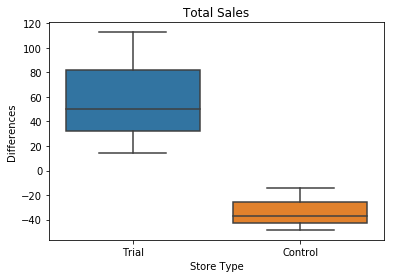

In [64]:
sales_diffs = {'Differences': [diff_sales_77, diff_sales_86, diff_sales_88, diff_sales_233, diff_sales_114, diff_sales_14], 'Store Type': ['Trial', 'Trial', 'Trial', 'Control', 'Control', 'Control']}
sales_diffs_df = pd.DataFrame(data=sales_diffs)
sns.boxplot(x='Store Type', y='Differences', data=sales_diffs_df)
plt.title('Total Sales')

Text(0.5,1,'Total Customers')

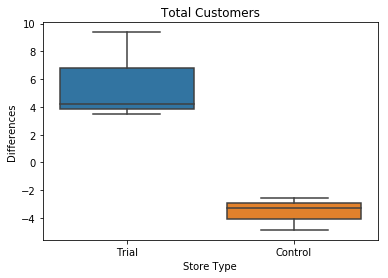

In [65]:
customers_diffs = {'Differences': [diff_customers_77, diff_customers_86, diff_customers_88, diff_customers_233, diff_customers_114, diff_customers_14], 'Store Type': ['Trial', 'Trial', 'Trial', 'Control', 'Control', 'Control']}
customers_diffs_df = pd.DataFrame(data=customers_diffs)
sns.boxplot(x='Store Type', y='Differences', data=customers_diffs_df)
plt.title('Total Customers')

Text(0.5,1,'Average Transactions Per Customer')

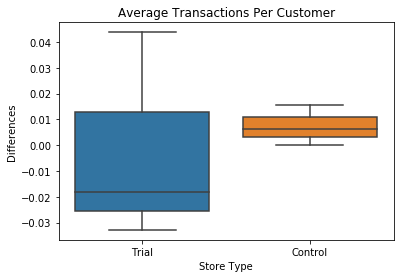

In [66]:
transactions_diffs = {'Differences': [diff_transactions_77, diff_transactions_86, diff_transactions_88, diff_transactions_233, diff_transactions_114, diff_transactions_14], 'Store Type': ['Trial', 'Trial', 'Trial', 'Control', 'Control', 'Control']}
transactions_diffs_df = pd.DataFrame(data=transactions_diffs)
sns.boxplot(x='Store Type', y='Differences', data=transactions_diffs_df)
plt.title('Average Transactions Per Customer')

### Findings

Through the uplift analysis, comparing the changes in 3 metrics over the trial period for three trial-control store pairs, we have found that in two of the metrics, total sales and total customers, the trial stores experienced a significant improvement compared to the control stores. In the last metric, average number of transactions per customer, there was not an improvement.

We can use these results to infer that the improvement in total sales was not due to an increase in average sales per customer, but due to an increase in total number of unique customers making transactions at the trial stores. As such we can recommend to the category manager for chips that the new trial layouts appear to have a beneficial effect on total sales and total customers.

As we did not select control stores by taking the last metric into account, further analysis might go about the selection of control stores differently. It would be possible to select several control stores for each trial store based on how strongly a given store correlates with the trial store on a single metric like total sales. In this way, the metrics could be better isolated and the effects of the trial layout on the performance of each metric could be even more clearly determined.